In [1]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
import fastHDMI as mi

# Calculate MI for ABIDE data
## this block is only to be run on Compute Canada

In [ ]:
csv_file = r"/home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
abide = pd.read_csv(csv_file, encoding='unicode_escape', engine="c")
# abide = dd.read_csv(csv_file, sample=1250000)

_abide_name = abide.columns.tolist()[1:]
# _abide_name = list(abide.columns)[1:]

# print(_abide_name)

abide_name = [_abide_name[-1]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas

mi_output = mi.binary_filter_csv_parallel(csv_file,
                                          _usecols=abide_name,
                                          csv_engine="c",
                                          sample=1250000)
np.save(r"/home/kyang/ABIDE_MI_output", mi_output)

pearson_output = mi.Pearson_filter_csv_parallel(csv_file,
                                                _usecols=abide_name,
                                                csv_engine="c",
                                                sample=1250000)
np.save(r"/home/kyang/ABIDE_Pearson_output", pearson_output)

# Plots

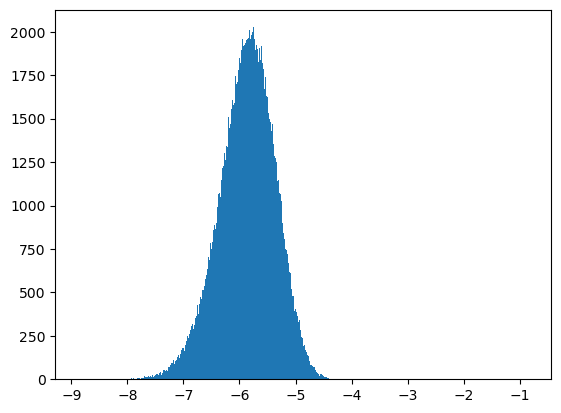

In [2]:
abide_mi = np.load(r"./ABIDE_MI_output.npy")
plt.hist(np.log(abide_mi), 500)
plt.show()

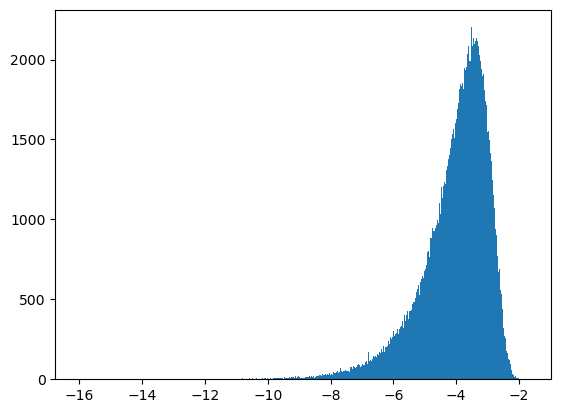

In [3]:
abide_pearson = np.load(r"./ABIDE_Pearson_output.npy")
plt.hist(np.log(np.abs(abide_pearson)), 500)
plt.show()

# Comparing two ranking with Kendall's $\tau$

The results show that the two ranking by mutual information and Pearson's correlation vary greatly by Kendall's tau -- I also tried the Pearson's correlation between two ranking (not that I should do this) and the correlation is also very small.

**So in summary, the two ranking vary greatly.**

In [4]:
print("Kendall's tau: \n",
      kendalltau(rankdata(-abide_mi), rankdata(-abide_pearson)))
print("Pearson's correlation: \n",
      np.corrcoef(rankdata(-abide_mi), rankdata(-abide_pearson)))

Kendall's tau: 
 KendalltauResult(correlation=0.030266310688428177, pvalue=3.487586021636743e-69)
Pearson's correlation: 
 [[1.         0.04746399]
 [0.04746399 1.        ]]
